## dataload & FeatureEngineering

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno
import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')

def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

def feature_engineering(df):
    uid2idx = {v:k for k,v in enumerate(sorted(df.userID.unique()))}
    ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}
    test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # userID, assessmentItemID, testId 라벨인코딩
    df2['uidIdx'] = df2.userID.map(uid2idx)
    df2['assIdx'] = df2.assessmentItemID.map(ass2idx)
    df2['testIdx'] = df2.testId.map(test2idx)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    # 유저별 문제푼 시간 Cumsum
    df2['solvesec_cumsum'] = df2.groupby(['userID','testId'])['solvesec_3600'].cumsum()%3601
    df2['solvecumsum_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600,7200]
    df2.loc[(df2.solvesec_cumsum==0), 'solvecumsum_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec_cumsum>s) & (df2.solvesec_cumsum<=e),'solvecumsum_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec_cumsum>=tc[-1]),'solvecumsum_category'] = f"{i+2} - ({e}, )"
    solvecumsum_category2idx={k:v for v,k in enumerate(sorted(df2.solvecumsum_category.unique()))}
    df2['solvecumsum_category'] = df2.solvecumsum_category.map(solvecumsum_category2idx)
    
    ## big_category
    # big_category 전체 정답률, 표준편차
    big_category_answermean = dict(df2.groupby("big_category").answerCode.mean())
    big_category_answerstd = dict(df2.groupby("big_category").answerCode.std())
    df2['big_category_acc'] = df2.big_category.map(big_category_answermean)
    df2['big_category_std'] = df2.big_category.map(big_category_answerstd)

    # 유저별 big category 문제 푼 횟수
    df2['big_category_cumconut'] = df2.groupby(['userID','big_category']).answerCode.cumcount()

    # 유저별 정답률, 표준 편차
    df2_user_big_ans = df2.groupby(['userID','big_category']).answerCode.mean().reset_index()
    df2_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
    df2 = df2.merge(df2_user_big_ans,on=['userID','big_category'])

    df2_user_big_ans_std = df2.groupby(['userID','big_category']).answerCode.std().reset_index()
    df2_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
    df2 = df2.merge(df2_user_big_ans_std,on=['userID','big_category'])

    # 문제별 맞춘 횟수 + log1p
    df2['big_category_answer'] = df2.groupby(['userID','big_category']).answerCode.transform(lambda x: x.cumsum().shift(1))
    df2['big_category_answer_log1p'] = np.log1p(df2.big_category_answer)
    
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    return df2

train['kind']='train'
test['kind']='test'
df = pd.concat([train,test])
df = feature_engineering(df)

In [6]:
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,time_category,solvesec_cumsum,solvecumsum_category,big_category_acc,big_category_std,big_category_cumconut,big_category_user_acc,big_category_user_std,big_category_answer,big_category_answer_log1p
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,0,0.0,0,0.711898,0.453371,0,0.791908,0.406531,NaN,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,1,3.0,1,0.711898,0.453371,1,0.791908,0.406531,1.0,0.693147
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,train,0,5356,975,...,3,11.0,4,0.711898,0.453371,2,0.791908,0.406531,2.0,1.098612


## big category별 정답률, 표준편차

In [5]:
big_category_answermean = dict(df.groupby("big_category").answerCode.mean())
big_category_answermean

{1: 0.8012411522633744,
 2: 0.737514713300824,
 3: 0.7017333992420498,
 4: 0.6797138103161398,
 5: 0.6586488250652741,
 6: 0.7118980934705584,
 7: 0.5211671424040596,
 8: 0.5002243059385917,
 9: 0.4544701860995063}

In [6]:
big_category_answerstd = dict(df.groupby("big_category").answerCode.std())
big_category_answerstd

{1: 0.3996850275695488,
 2: 0.4406501820816578,
 3: 0.4581097590262003,
 4: 0.46727857182167,
 5: 0.47473472730999405,
 6: 0.4533710520545168,
 7: 0.5003328445730407,
 8: 0.5008018469103586,
 9: 0.4982143771648111}

In [7]:
df['big_category_acc'] = df.big_category.map(big_category_answermean)
df['big_category_std'] = df.big_category.map(big_category_answerstd)

In [8]:
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,tag_sum,Timestamp2,solvetime,solvesec,solvesec_3600,time_category,solvesec_cumsum,solvecumsum_category,big_category_acc,big_category_std
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,718,2020-03-24 00:17:11,0 days 00:00:00,0.0,0.0,0,0.0,0,0.711898,0.453371
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,3439,2020-03-24 00:17:14,0 days 00:00:03,3.0,3.0,1,3.0,1,0.711898,0.453371
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,train,0,5356,975,...,3439,2020-03-24 00:17:22,0 days 00:00:08,8.0,8.0,3,11.0,4,0.711898,0.453371


## 각 유저별 big category별 정답률 평균

In [24]:
df_user_big_ans = df.groupby(['userID','big_category']).answerCode.mean().reset_index()
df_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
df_user_big_ans[:3]

,userID,big_category,big_category_user_acc
0,0,2,0.722222
1,0,6,0.791908
2,0,8,0.468320


In [ ]:
df

In [26]:
df = df.merge(df_user_big_ans,on=['userID','big_category'])

## 각 유저별 big category별 정답률 표준편차

In [27]:
df_user_big_ans_std = df.groupby(['userID','big_category']).answerCode.std().reset_index()
df_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
df_user_big_ans_std[:3]

,userID,big_category,big_category_user_std
0,0,2,0.454257
1,0,6,0.406531
2,0,8,0.499684


In [28]:
df = df.merge(df_user_big_ans_std,on=['userID','big_category'])

In [3]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category'],
      dtype='object')

In [61]:
df[df.userID==0][['userID','big_category','big_category_user_acc','big_category_user_std']]

,userID,big_category,big_category_user_acc,big_category_user_std
0,0,6,0.791908,0.406531
1,0,6,0.791908,0.406531
2,0,6,0.791908,0.406531
3,0,6,0.791908,0.406531
4,0,6,0.791908,0.406531
5,0,6,0.791908,0.406531
6,0,6,0.791908,0.406531
7,0,6,0.791908,0.406531
8,0,6,0.791908,0.406531
9,0,6,0.791908,0.406531


In [4]:
df.groupby('big_category').answerCode.agg(['mean','std'])

,mean,std
big_category,,
1,0.801241,0.399685
2,0.737515,0.440650
3,0.701733,0.458110
4,0.679714,0.467279
5,0.658649,0.474735
6,0.711898,0.453371
7,0.521167,0.500333
8,0.500224,0.500802
9,0.454470,0.498214


In [58]:
df.groupby("big_category").answerCode.mean()

big_category
1    0.801241
2    0.737515
3    0.701733
4    0.679714
5    0.658649
6    0.711898
7    0.521167
8    0.500224
9    0.454470
Name: answerCode, dtype: float64

In [11]:
df.sort_values(['userID','Timestamp'],inplace=True)

## 각 유저의 big category 별 문제 푼 횟수

In [12]:
df['big_category_cumconut'] = df.groupby(['userID','big_category']).answerCode.cumcount()

In [18]:
df[df.userID==7331][['userID','big_category','big_category_cumconut']][:10]

,userID,big_category,big_category_cumconut
2524767,7331,6,0
2524768,7331,6,1
2524769,7331,6,2
2524770,7331,6,3
2524771,7331,6,4
2524772,7331,6,5
2524773,7331,6,6
2524774,7331,2,0
2524775,7331,2,1
2524776,7331,2,2


## 각 유저의 big category 별 문제 맞춘 횟수

In [37]:
df.sort_values(['userID','Timestamp'],inplace=True)

In [42]:
df['big_category_answer'] = df.groupby(['userID','big_category']).answerCode.transform(lambda x: x.cumsum().shift(1))

In [43]:
df[df.userID==7331][['userID','assessmentItemID','big_category','answerCode','user_correct_answer','big_category_answer']]

,userID,assessmentItemID,big_category,answerCode,user_correct_answer,big_category_answer
2524767,7331,A060130001,6,1,NaN,NaN
2524768,7331,A060130002,6,0,1.0,1.0
2524769,7331,A060130003,6,1,1.0,1.0
2524770,7331,A060130004,6,0,2.0,2.0
2524771,7331,A060130005,6,0,2.0,2.0
2524772,7331,A060130006,6,1,2.0,2.0
2524773,7331,A060130007,6,1,3.0,3.0
2524774,7331,A020118001,2,1,4.0,NaN
2524775,7331,A020118002,2,1,5.0,1.0
2524776,7331,A020118003,2,0,6.0,2.0


In [46]:
df.big_category_answer.info()
2526700 - 2506961

<class 'pandas.core.series.Series'>
Int64Index: 2526700 entries, 0 to 2526699
Series name: big_category_answer
Non-Null Count    Dtype  
--------------    -----  
2506961 non-null  float64
dtypes: float64(1)
memory usage: 38.6 MB


19739

<AxesSubplot:>

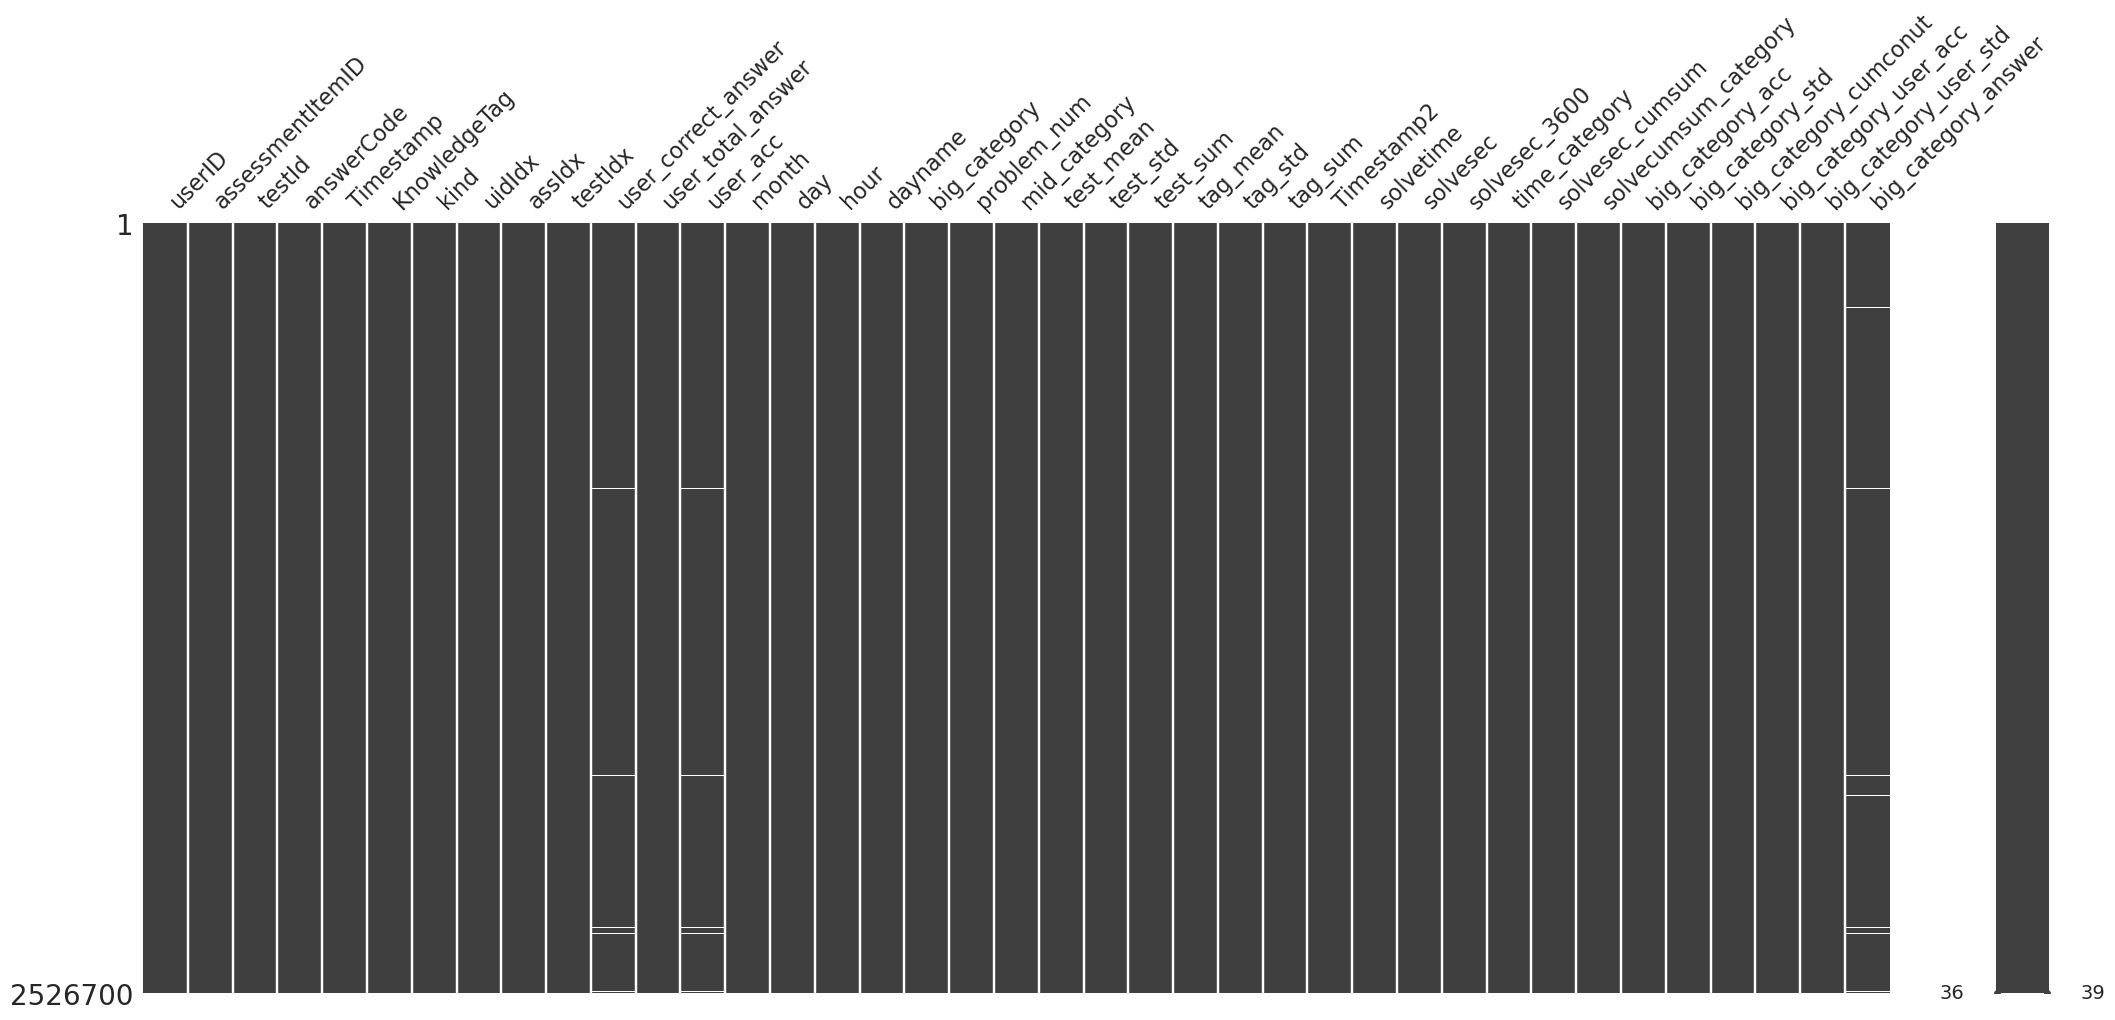

In [44]:
missingno.matrix(df)

<AxesSubplot:ylabel='Density'>

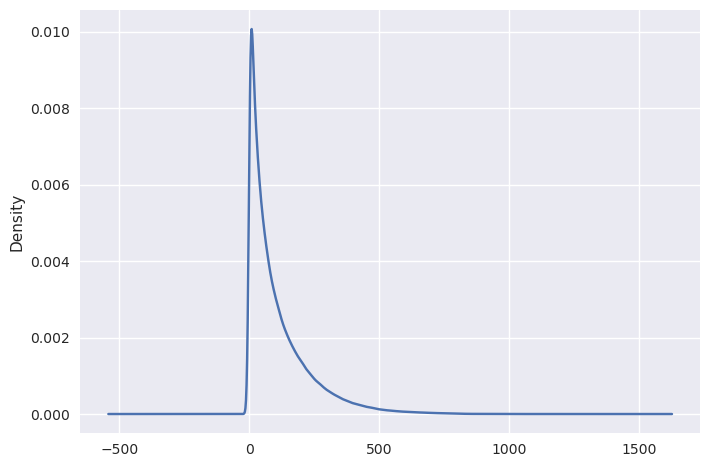

In [48]:
df.big_category_answer.dropna().plot(kind='kde')

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

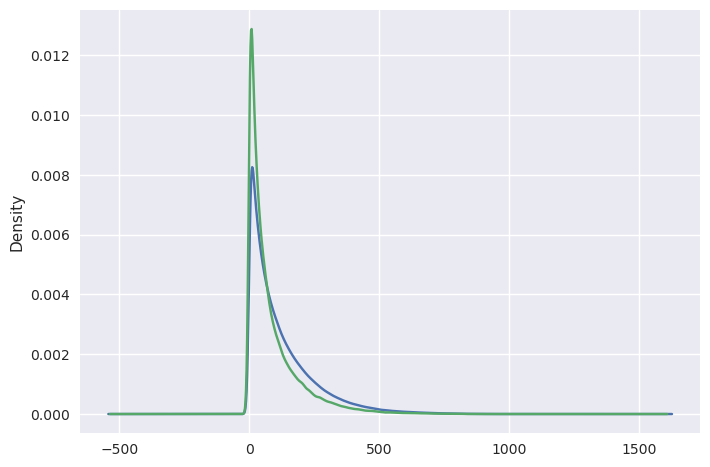

In [49]:
df[df.answerCode==1].big_category_answer.dropna().plot(kind='kde')
df[df.answerCode==0].big_category_answer.dropna().plot(kind='kde')

<AxesSubplot:ylabel='Density'>

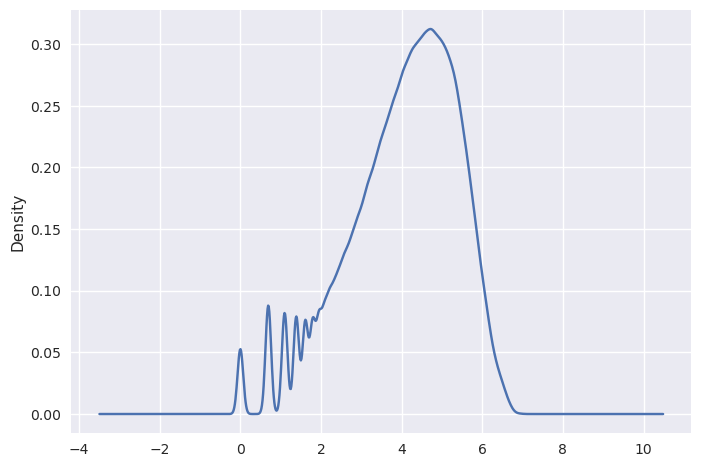

In [51]:
np.log1p(df.big_category_answer.dropna()).plot(kind='kde')

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

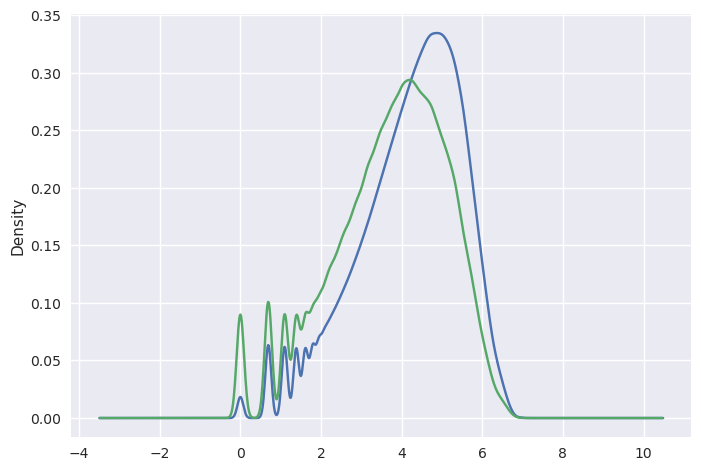

In [52]:
np.log1p(df[df.answerCode==1].big_category_answer.dropna()).plot(kind='kde')
np.log1p(df[df.answerCode==0].big_category_answer.dropna()).plot(kind='kde')

In [55]:
df['big_category_answer_log1p'] = np.log1p(df.big_category_answer)

In [57]:
df[:10]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,time_category,solvesec_cumsum,solvecumsum_category,big_category_acc,big_category_std,big_category_cumconut,big_category_user_acc,big_category_user_std,big_category_answer,big_category_answer_log1p
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,0,0.0,0,0.711898,0.453371,0,0.791908,0.406531,NaN,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,1,3.0,1,0.711898,0.453371,1,0.791908,0.406531,1.0,0.693147
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,train,0,5356,975,...,3,11.0,4,0.711898,0.453371,2,0.791908,0.406531,2.0,1.098612
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,train,0,5357,975,...,2,18.0,4,0.711898,0.453371,3,0.791908,0.406531,3.0,1.386294
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,train,0,5358,975,...,2,25.0,4,0.711898,0.453371,4,0.791908,0.406531,4.0,1.609438
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,train,0,5359,975,...,4,36.0,4,0.711898,0.453371,5,0.791908,0.406531,5.0,1.791759
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,train,0,5367,977,...,9,3600.0,8,0.711898,0.453371,6,0.791908,0.406531,6.0,1.945910
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,train,0,5368,977,...,2,6.0,2,0.711898,0.453371,7,0.791908,0.406531,6.0,1.945910
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,train,0,5369,977,...,5,70.0,5,0.711898,0.453371,8,0.791908,0.406531,7.0,2.079442
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,train,0,5370,977,...,4,85.0,5,0.711898,0.453371,9,0.791908,0.406531,8.0,2.197225


## big_category 별 과거에 맞춘 문제수/과거에 푼 문제수로 과거 평균 정답률 피처

In [7]:
df['big_category_answer'] = df['big_category_answer'].fillna(0)

df['big_category_user_cum_acc'] = (df['big_category_answer'] / df['big_category_cumconut']).fillna(0)

df.reset_index(drop=True,inplace=True)

df_user_big_ans = df[df.userID == df.userID.shift(-1)].groupby(['userID','big_category']).answerCode.mean().reset_index()
df_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
df = df.merge(df_user_big_ans,on=['userID','big_category'])

df_user_big_ans_std = df[df.userID == df.userID.shift(-1)].groupby(['userID','big_category']).answerCode.std().reset_index()
df_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
df = df.merge(df_user_big_ans_std,on=['userID','big_category'])

In [21]:
df[df.userID==7331][['userID','assessmentItemID','answerCode','big_category','big_category_answer','big_category_cumconut','big_category_user_cum_acc','kind']]

,userID,assessmentItemID,answerCode,big_category,big_category_answer,big_category_cumconut,big_category_user_cum_acc,kind
2524767,7331,A060130001,1,6,0.0,0,0.000000,train
2524768,7331,A060130002,0,6,1.0,1,1.000000,train
2524769,7331,A060130003,1,6,1.0,2,0.500000,train
2524770,7331,A060130004,0,6,2.0,3,0.666667,train
2524771,7331,A060130005,0,6,2.0,4,0.500000,train
2524772,7331,A060130006,1,6,2.0,5,0.400000,train
2524773,7331,A060130007,1,6,3.0,6,0.500000,train
2524774,7331,A020118001,1,2,0.0,0,0.000000,train
2524775,7331,A020118002,1,2,1.0,1,1.000000,train
2524776,7331,A020118003,0,2,2.0,2,1.000000,train


## 내보내기

In [56]:
df2 = df.copy()
export(df2, output='after_fe_train_test_bigcategory_fe.pkl')

Write: /opt/ml/input/data/after_fe_train_test_bigcategory_fe.pkl
